In [1]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads/ra_joint_predictions')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
import os
import tensorflow as tf
import tensorflow_addons as tfa
from utils.config import Config

import PIL
import PIL.ImageOps
from tensorflow.keras.utils import plot_model
configuration = Config()
from tensorflow.keras.models import load_model

import itertools
import seaborn as sns

AUTOTUNE = tf.data.experimental.AUTOTUNE

from dataset.ops import dataset_ops
import dataset.ops.image_ops as ops
import model.RSNA_model
import model.NIH_model
from dataset import joint_dataset, rsna_joint_dataset

In [3]:
# reload the library
import importlib
import types
import os

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        importlib.reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

reload_package(rsna_joint_dataset)


In [9]:
a = keras.models.load_model("resources/complex_model_RSNA_pretrain_with_NIH_pretrain_model_200.h5")

2020-03-07 19:35:09,963;WARNING - Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


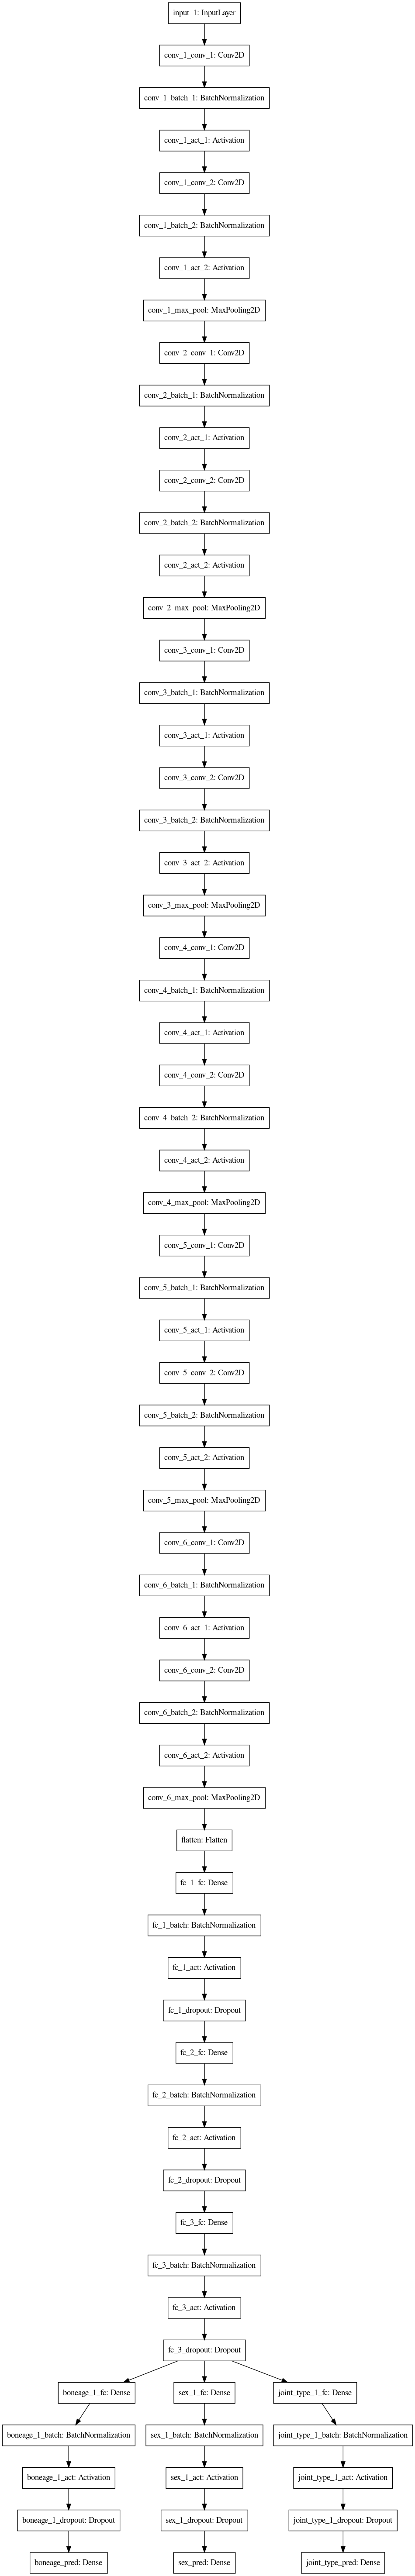

In [11]:
plot_model(a)

In [16]:
b = keras.models.load_model("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/RA2_alpine_lads/trained_models/pretrain_models/complex_rsna_pretrain_v1.h5")

2020-03-07 19:39:08,911;WARNING - No training configuration found in save file: the model was *not* compiled. Compile it manually.


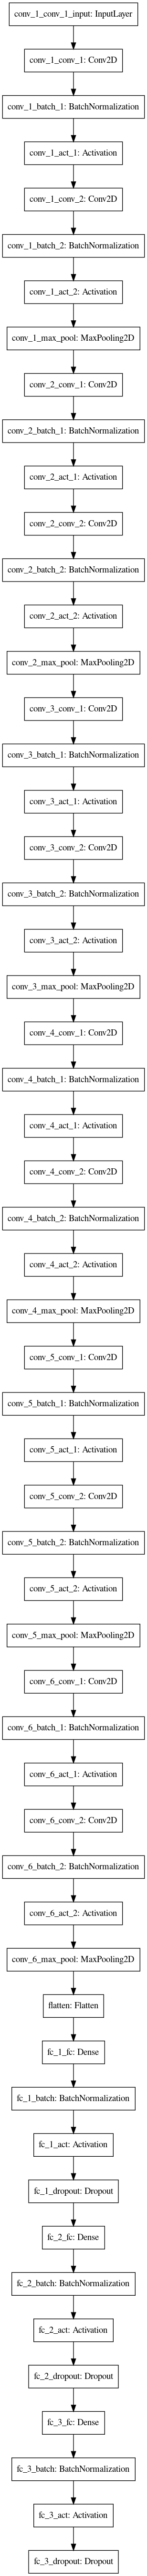

In [17]:
plot_model(b)

In [4]:
NIH_model = model.NIH_model.create_Xception_multioutput(configuration)

In [15]:
NIH_model.summary()

Model: "Xception_multiout_NIH"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 2048)         20860904    input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          1049088     xception[1][0]                   
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 512)          2048        dense_2[0][0]                    
______________________________________________________________________________

In [4]:
NIH_model = model.NIH_model.create_complex_joint_multioutput(configuration)

In [5]:
weights="weights/NIH_new_pretrain_model_100"

In [6]:
NIH_model.load_weights(weights)

In [9]:
keras.models.save_model(NIH_model,"weights/NIH_new_pretrain_model_100.h5")

In [13]:
model.NIH_model.create_VGG_multioutput(configuration).summary()

Model: "complex_multiout_NIH"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 512)          14713536    input_10[0][0]                   
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 512)          262656      vgg16[1][0]                      
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 512)          2048        dense_11[0][0]                   
_______________________________________________________________________________

In [16]:
keras.applications.xception.Xception(include_top=False, weights=None,input_shape=[configuration.img_height,configuration.img_width,1], pooling="avg").summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 288         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [5]:
RSNA_model = keras.Model(NIH_model.input, NIH_model.layers[-4].output)

In [44]:
RSNA_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv_1_conv_1 (Conv2D)       (None, 224, 224, 32)      320       
_________________________________________________________________
conv_1_batch_1 (BatchNormali (None, 224, 224, 32)      128       
_________________________________________________________________
conv_1_act_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv_1_conv_2 (Conv2D)       (None, 224, 224, 32)      9248      
_________________________________________________________________
conv_1_batch_2 (BatchNormali (None, 224, 224, 32)      128       
_________________________________________________________________
conv_1_act_2 (Activation)    (None, 224, 224, 32)      0   

In [6]:
RSNA_NEW_MODEL = model.RSNA_model.complex_joint_finetune_model(configuration)

2020-03-17 08:30:30,039;WARNING - Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


In [19]:
RSNA_NEW_MODEL.load_weights("weights/complex_model_RSNA_pretrain_with_NIH_pretrainafter_model_200")


In [20]:
keras.models.save_model(RSNA_NEW_MODEL,"resources/complex_model_RSNA_pretrain_with_NIH_pretrain_model_200.h5")

In [7]:
for layer in RSNA_NEW_MODEL.layers:
    layer.trainable = True

In [4]:
joint_dataset, joint_val_dataset = rsna_joint_dataset.rsna_joint_dataset(configuration).create_rsna_joints_dataset(val_split = True)

2020-03-17 09:05:26,072;WARNING - Missing permissions to create directory for caching!


In [ ]:
for a,b in joint_dataset.take(100):
    continue

In [6]:
chan = dataset_ops.get_3_channels(joint_dataset)

In [10]:
def _split_outcomes(dataset, no_joint_types = 13):
    def __split_outcomes(x, y):
        split_y = tf.split(y, [1, 1, no_joint_types], 1)

        return x, (split_y[0], split_y[1], split_y[2])

    return dataset.map(__split_outcomes, num_parallel_calls=AUTOTUNE)

In [7]:
for x,y in chan.take(1):
    x

In [8]:
x

<tf.Tensor: id=1221, shape=(64, 224, 224, 3), dtype=float32, numpy=
array([[[[0.3423163 , 0.3423163 , 0.3423163 ],
         [0.34930682, 0.34930682, 0.34930682],
         [0.35842875, 0.35842875, 0.35842875],
         ...,
         [0.28022748, 0.28022748, 0.28022748],
         [0.2781541 , 0.2781541 , 0.2781541 ],
         [0.28511867, 0.28511867, 0.28511867]],

        [[0.34075055, 0.34075055, 0.34075055],
         [0.34671754, 0.34671754, 0.34671754],
         [0.35261634, 0.35261634, 0.35261634],
         ...,
         [0.28469902, 0.28469902, 0.28469902],
         [0.2906012 , 0.2906012 , 0.2906012 ],
         [0.29519585, 0.29519585, 0.29519585]],

        [[0.3299751 , 0.3299751 , 0.3299751 ],
         [0.3385941 , 0.3385941 , 0.3385941 ],
         [0.3461404 , 0.3461404 , 0.3461404 ],
         ...,
         [0.28912106, 0.28912106, 0.28912106],
         [0.29594746, 0.29594746, 0.29594746],
         [0.3057974 , 0.3057974 , 0.3057974 ]],

        ...,

        [[0.08945131, 0.

In [1]:
base_name = complex_model_RSNA_pretrain_with_NIH_pretrain

In [8]:
for epoch in range(0,200,10):
    os.rename(f"weights/complex_model_RSNA_pretrain_with_NIH_pretrainafter_model_{epoch}.h5",f"weights/complex_model_RSNA_wrist_pretrain_with_NIH_pretrainafter_model_{epoch}.h5")

In [ ]:
model = model.RSNA_model.complex_joint_finetune_model(configuration, weights = "weights/NIH_new_pretrain_model_100.h5", no_joint_types = 13)

model.summary()

from train.pretrain_RSNA_joints import finetune_model
finetune_model(model, "complex_model_RSNA_joints_pretrain_with_NIH_pretrain", joint_dataset, joint_val_dataset, n_outputs = 13)
